# Computing behavioural syllables using `keypoint-moseq`

In this notebook, we will explore a few simple analyses we can carry out with a trained `keypoint-moseq` model applied to new data.

Applying a trained model to new data may be useful if you have collected data for new experiments but would like to maintain an existing set of syllables. 

We assume that you have gone through the `EPM_train_keypoint_moseq.ipynb` notebook, which explains how to create and train a `keypoint-moseq` model on a set of 10 videos. We also assume that you have downloaded the `mouse-EPM` folder with the sample data.

This notebook is based on the one provided as part of the [`keypoint-moseq` documentation](https://github.com/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb).  

## A. Setup
### A1. Create a conda environment and install the required packages
We will use the conda environment from the `keypoint-moseq` documentation, with an optional additional package.

In a terminal, clone the `keypoint-moseq` repository (ideally somewhere outside the `course-behavioural-analysis` repository):
```bash
git clone https://github.com/dattalab/keypoint-moseq
cd keypoint-moseq
```

Then, create the appropriate conda environment for your platform. For example, for a Linux installation with a GPU we would run:
```bash
# Linux (GPU)
conda env create -f conda_envs/environment.linux_gpu.yml
``` 
For other platforms, please see the full list of commands in the [keypoint-moseq docs](https://keypoint-moseq.readthedocs.io/en/latest/install.html#install-using-conda).


This last command will create a conda environment called `keypoint_moseq`. We can activate this environment by running:
```bash
conda activate keypoint-moseq
```

Optionally, to display interactive plots in the notebook, we can install the `ipympl` package in the `keypoint-moseq` environment:
```bash
pip install ipympl 
```

Once all required packages are installed, you can re-open this notebook and select the `keypoint-moseq` kernel to get started.

### A2. Import required packages

In [3]:
import itertools
import keypoint_moseq as kpms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [4]:
# Optional: to use interactive plots, install `ipympl` and run this cell
%matplotlib widget

### A3. Specify paths to trained model and new data

You should modify the `DATA_DIR` path below to point to the directory where you downloaded the `mouse-EPM` folder containing the sample data.

In [7]:
DATA_DIR = Path.home() / "Data" / "behav-analysis-course" / "mouse-EPM"

# path to new data 
filename = "sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000.h5"
filename_no_ext = Path(filename).stem
dlc_predictions_dir = DATA_DIR / "derivatives" / "software-DLC_predictions"
file_path = dlc_predictions_dir / filename
# sample frame (used as background for plotting)
video1_frame_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-170049_frame.png"

# path to kpt-moseq trained model
project_dir = DATA_DIR / "derivatives" / "software-kptmoseq_n-10_project"
model_name = '2024_09_19-15_54_42'

## B. Apply trained `keypoint-moseq` model to new SLEAP predictions

First we load the trained `keypoint-moseq` model and its corresponding `config` dictionary.

In [8]:
# load model
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# load config 
config = kpms.load_config(project_dir)  # noqa: E731

We can print the keys and values in the config to inspect it further.

In [9]:
# print config
for k,v in config.items():
    print(f"{k}: {v}")

bodyparts: ['snout', 'left_ear', 'right_ear', 'centre', 'lateral_left', 'lateral_right', 'tailbase', 'tail_end']
use_bodyparts: ['snout', 'left_ear', 'right_ear', 'centre', 'lateral_left', 'lateral_right', 'tailbase']
skeleton: [['snout', 'left_ear'], ['snout', 'right_ear'], ['snout', 'centre'], ['centre', 'lateral_left'], ['centre', 'lateral_right'], ['centre', 'tailbase'], ['tailbase', 'lateral_left'], ['tailbase', 'lateral_right']]
anterior_bodyparts: ['snout']
posterior_bodyparts: ['tailbase']
added_noise_level: 0.1
PCA_fitting_num_frames: 1000000
conf_threshold: 0.6
error_estimator: {'intercept': 0.8, 'slope': -0.6}
obs_hypparams: {'nu_s': 5, 'nu_sigma': 100000.0, 'sigmasq_0': 0.1, 'sigmasq_C': 0.1}
ar_hypparams: {'K_0_scale': 10.0, 'S_0_scale': 0.01, 'latent_dim': 7, 'nlags': 3}
trans_hypparams: {'alpha': 5.7, 'gamma': 1000.0, 'kappa': 1000000.0, 'num_states': 100}
cen_hypparams: {'sigmasq_loc': 0.5}
recording_name_suffix: 
verbose: False
conf_pseudocount: 0.001
video_dir: /media

To apply the new data to the `keypoint-moseq` model, we need to first parse it and format it as required.

In [10]:
# parse keypoint data
coordinates, confidences, bodyparts = kpms.load_keypoints(str(file_path), "deeplabcut")

# coordinates is a dictionary that for each DLC file, points
# to an array of size (nframes, n_keypoints, n_spatial_dimensions),
# that holds the position of every predicted keypoint, at every frame.
print('------')
print('Coordinates:')
print(coordinates.keys())
print(coordinates[filename_no_ext].shape)
print('------')

# confidences is a dictionary that for each DLC file, points
# to an array of size (nframes, n_keypoints) that holds the
# confidence values for each predicted keypoint.
print('Confidences:')
print(confidences.keys())
print(confidences[filename_no_ext].shape)
print('------')

# bodyparts is a list of the string labels applied to the keypoints in the data
print('Bodyparts')
print(bodyparts)

Loading keypoints: 100%|██████████████████| 1/1 [00:01<00:00,  1.17s/it]

------
Coordinates:
dict_keys(['sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000'])
(18485, 8, 2)
------
Confidences:
dict_keys(['sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000'])
(18485, 8)
------
Bodyparts
['snout', 'left_ear', 'right_ear', 'centre', 'lateral_left', 'lateral_right', 'tailbase', 'tail_end']


We now express the parsed data in the format that the model expects.

In [11]:
# format data for model
data, metadata = kpms.format_data(coordinates, confidences, **config)

After formatting the new data, we can apply the trained model to it. 

By default, the results for the new data will be added to the existing `results.h5` file that lives under keypoint_moseq_project_dir / model_name.

In our case, the file is at `mouse-EPM/derivatives/software-kptmoseq_n-10_project/2024_09_19-15_54_42/results.h5`.

In [12]:
# apply trained model to new data;
# the `apply_model` function extracts the results to a variable and 
# appends them to the existing results.h5 file.
results = kpms.apply_model(
    model, 
    data, 
    metadata, 
    project_dir, 
    model_name, 
    **config, 
)  

# optionally, rerun `save_results_as_csv` to export the new results as a csv
kpms.save_results_as_csv(results, project_dir, model_name)

Applying model: 100%|█████████████████| 500/500 [08:39<00:00,  1.04s/it]


Saved results to /home/sminano/swc/project_teaching_behaviour/mouse-
EPM/derivatives/software-
kptmoseq_n-10_project/2024_09_19-15_54_42/results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 23.57it/s]


The `results` variable contains the results only for the new data. 


In [13]:
print(results.keys())
print(results[filename_no_ext].keys())

dict_keys(['sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000'])
dict_keys(['syllable', 'latent_state', 'centroid', 'heading'])


To load all the analysed data, including the data used to fit the model, we can use the `load_results` function.

In [14]:
results_all = kpms.load_results(path=project_dir / model_name / "results.h5")

# check data inside
for k in results_all.keys():
    print(k)

M723400_EPM_20200317_152959980-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M723998_EPM_20200317_145552459-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M727755_EPM_20200317_170544999-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M727756_EPM_20200317_172001079-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M727780_EPM_20200317_174009609-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M727781_EPM_20200317_175421340-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M728731_EPM_20200317_154549993-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M729731_EPM_20200317_160124105-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M729733_EPM_20200317_180936869-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
M729734_EPM_20200317_182308312-convertedDLC_resnet50_MouseTopDownSep13shuffle1_340000
sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000


## C. Compute frequency of syllables in the new data

We can inspect how many times each syllable appears in the new data.

Remember that the syllables were computing using a larger dataset of keypoint predictions over 10 videos.

In [15]:
# extract array with the syllable assigned to every frame
syllables_per_frame = results[filename_no_ext]["syllable"]  # size of array: (nframes, )
print(f"Number of frames in new data: {syllables_per_frame.shape[0]}") 

# count the number of times each syllable appears in the video
syllables_count = {}
for syl in np.unique(syllables_per_frame):
    syllables_count[syl] = sum(syl == syllables_per_frame)

# sort syllables by count
syllables_count = dict(
    sorted(
        syllables_count.items(), 
        key=lambda item: item[1], 
        reverse=True
    )
)
print(f"Number of syllables identified in new data: {len(syllables_count.keys())}")

# print top 10 most frequent syllables
# (the syllable IDs are assigned based on their frequency in the training data)
n_frames = results[filename_no_ext]["syllable"].shape[0]
for syl, count in list(syllables_count.items())[:10]:
    print(f"Syllable id-{syl}: {(count/n_frames)*100:.2f} % of frames")

Number of frames in new data: 18485
Number of syllables identified in new data: 13
Syllable id-2: 44.37 % of frames
Syllable id-0: 24.57 % of frames
Syllable id-3: 15.61 % of frames
Syllable id-5: 9.16 % of frames
Syllable id-1: 4.05 % of frames
Syllable id-4: 0.97 % of frames
Syllable id-6: 0.71 % of frames
Syllable id-7: 0.21 % of frames
Syllable id-9: 0.12 % of frames
Syllable id-10: 0.09 % of frames


## D. Plot ethogram for new data

We can also compute an ethogram of the new data using the predicted syllables.

To do that, we first need to define all continuous sections of frames that share a common syllable. 

Specifically, we compute the start frame and the duration of each continuous chunk of syllables using the `itertools.groupby()` function.

In [17]:
# Find continuous chunks of frames with the same syllable
# itertools.groupby: generates a break or new group
# every time the value of the key function changes
syllable_chunks = [
    (key, len(list(group_iter)))
    for key, group_iter in itertools.groupby(syllables_per_frame)
]  # list of tuples, each tuple is a pair (syllable_id, lenght_of_chunk)

chunks_duration = [syl_dur for syl_id, syl_dur in syllable_chunks]
chunks_start = np.cumsum([0]+chunks_duration) - 0.5 # starting frame of each chunk

Then we can plot the data as an ethogram. For clarity, we focus on the first 1000 frames.

/tmp/ipykernel_410776/1508767421.py:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Text(0.5, 1.0, 'ethogram')

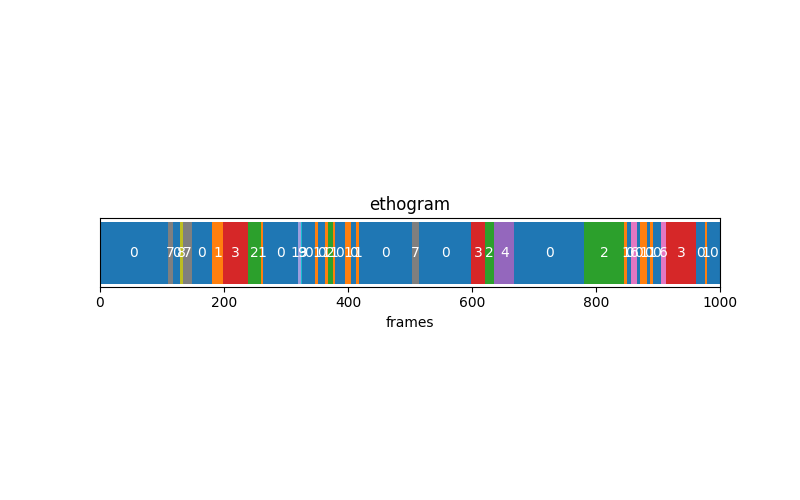

In [27]:
# prepare colormap for syllables
list_colors = (
    plt.get_cmap("tab10").colors  # 10 colors
    + plt.get_cmap("tab20b").colors  # 20 colors
)  # 30 colors, should be enough for the total number of syllables detected

# select maximum frames to plot
frames_max_to_plot = 1000

# plot ethogram as an horizontal bar plot
fig, ax = plt.subplots(1, 1, figsize=(8,5))
rects = ax.barh(
    y=results.keys(),
    width=chunks_duration,
    left=chunks_start[:-1],  
    height=1,
    color=[
        list_colors[syl_id%len(list_colors)] 
        for syl_id, syl_dur in syllable_chunks
    ],
)
ax.bar_label(
    rects, 
    labels=[syl_id for syl_id, syl_dur in syllable_chunks],
    label_type='center', 
    color='white'
)
ax.set_xlim(0, frames_max_to_plot)
ax.set_xlabel('frames')
ax.yaxis.set_visible(False)

ax.set_aspect(100)
ax.set_title('ethogram')

## E. Compute median duration per syllable and plot

We can compute the median duration of all syllables in the new data.

Keep in mind that the median syllable duration in the training data was ~16 frames

In [19]:
# compute median syllable duration
median_syllable_duration = np.median(chunks_duration)
print(f'The median syllable duration is {median_syllable_duration} frames')

The median syllable duration is 18.0 frames


Similarly, we can compute the median duration per syllable

In [20]:
# compute median duration per syllable ID
median_duration_per_syl = {}
for syl in list(syllables_count.keys()):
    median_duration_per_syl[syl] = np.median(
        [
            syl_dur 
            for (syl_id, syl_dur) in syllable_chunks 
            if syl_id == syl
        ]
    )  

for k,v in median_duration_per_syl.items():
    print(f"The median duration for syllable-id {k} is {v} frames")

The median duration for syllable-id 2 is 58.5 frames
The median duration for syllable-id 0 is 21.0 frames
The median duration for syllable-id 3 is 45.0 frames
The median duration for syllable-id 5 is 86.5 frames
The median duration for syllable-id 1 is 4.0 frames
The median duration for syllable-id 4 is 13.5 frames
The median duration for syllable-id 6 is 7.0 frames
The median duration for syllable-id 7 is 10.0 frames
The median duration for syllable-id 9 is 4.0 frames
The median duration for syllable-id 10 is 5.0 frames
The median duration for syllable-id 8 is 3.0 frames
The median duration for syllable-id 14 is 6.0 frames
The median duration for syllable-id 13 is 5.0 frames


To plot all the results together, we can use a simple scatter plot. The red reference line indicates the median duration across all syllables.

Median syllable duration (frames): 18.0
Median syllable duration (ms): 600.0


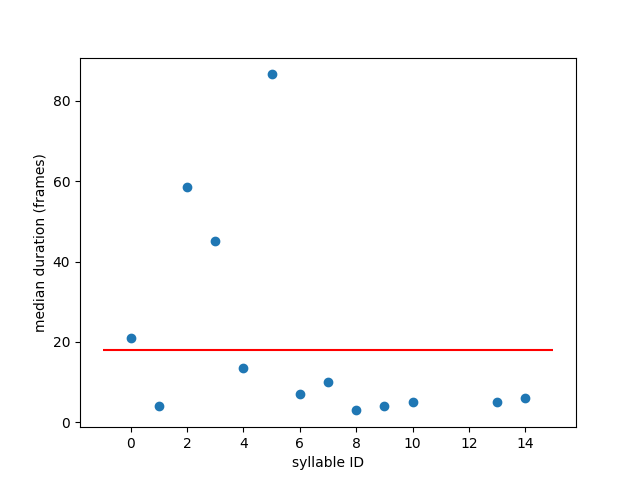

In [22]:
# plot median duration per syllable
fps = 30 

fig, ax = plt.subplots(1, 1)
ax.scatter(
    x=median_duration_per_syl.keys(),
    y=median_duration_per_syl.values(),
)
ax.hlines(
    y=median_syllable_duration,
    xmin=-1,
    xmax=max(median_duration_per_syl.keys()) + 1,
    colors="r",
)
ax.set_xlabel("syllable ID")
ax.set_ylabel("median duration (frames)")

print(f"Median syllable duration (frames): {median_syllable_duration}")
print(f"Median syllable duration (ms): {1000*median_syllable_duration/fps}")

## F. Visualise the most frequent syllables in the new data

In this section, we use the ethogram visualisation to get an intuition of how frequent specific syllables are.

For each syllable, we plot the frames in which it is present in red, and the rest of frames in grey.

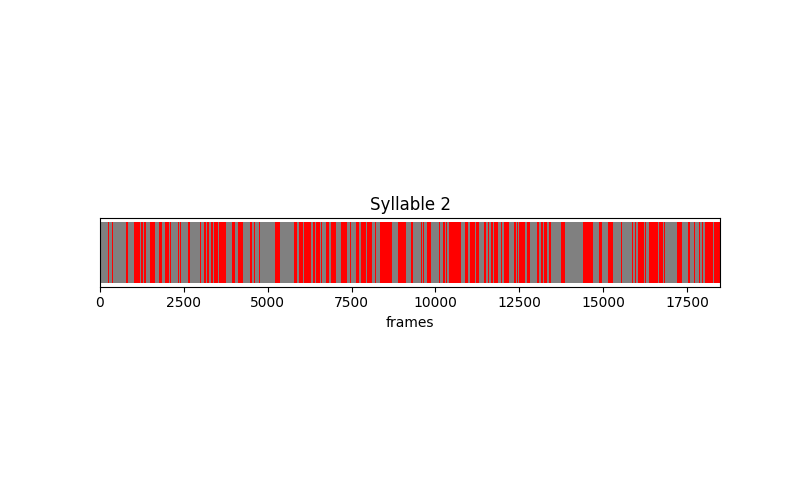

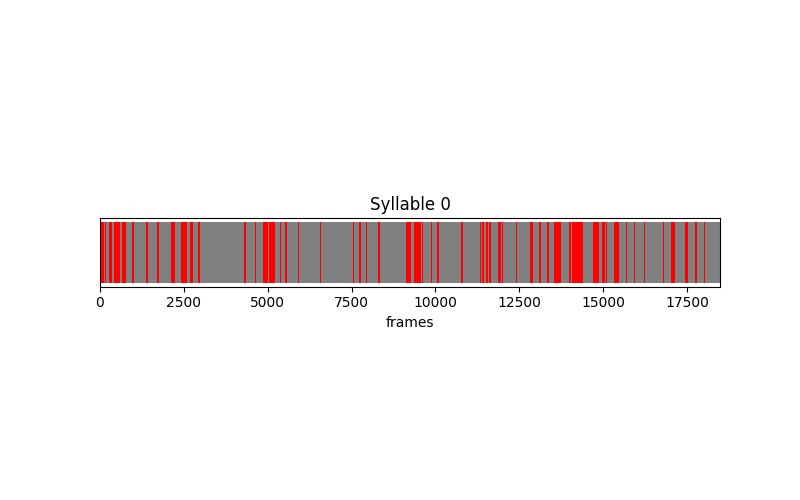

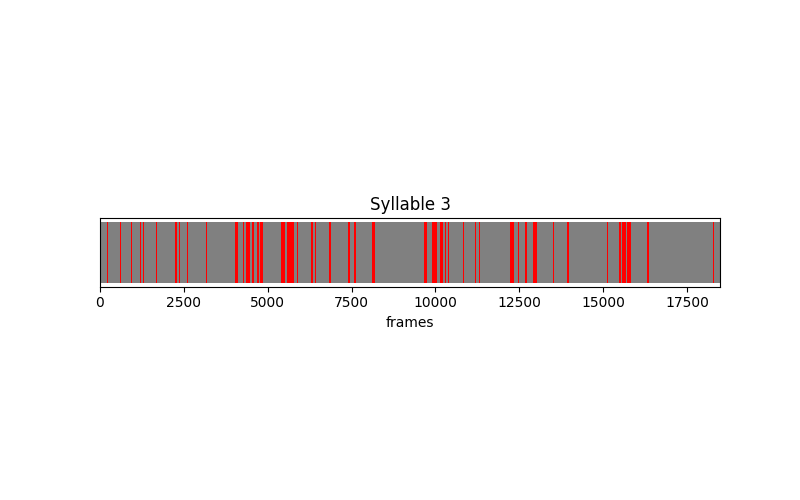

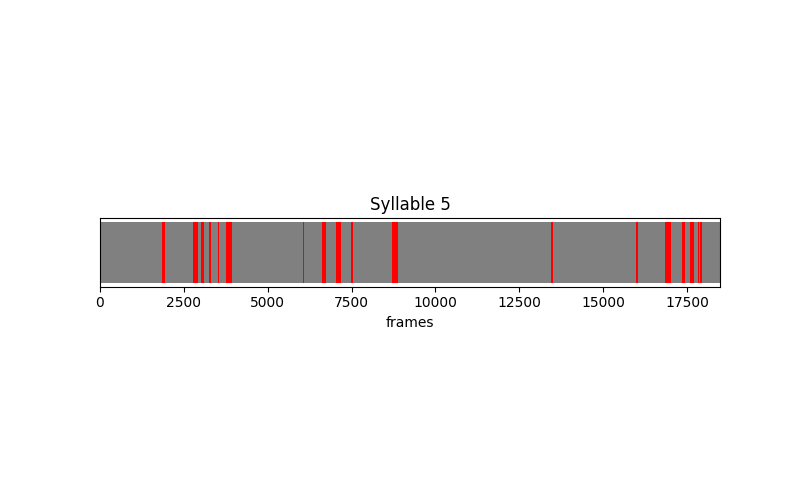

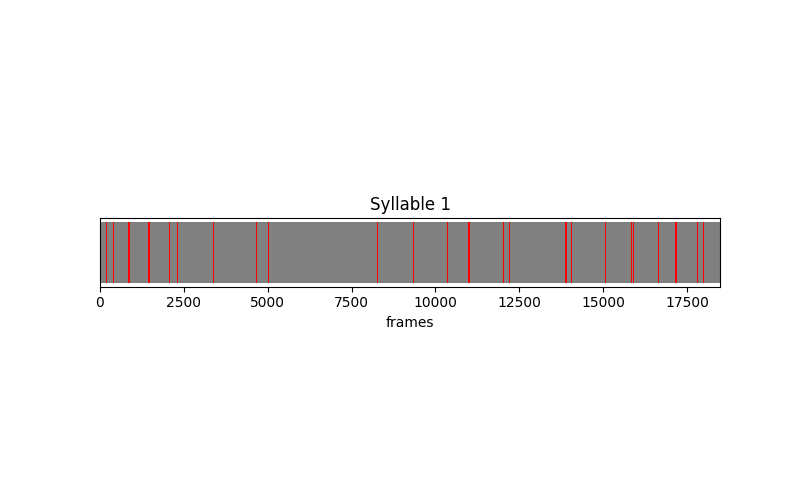

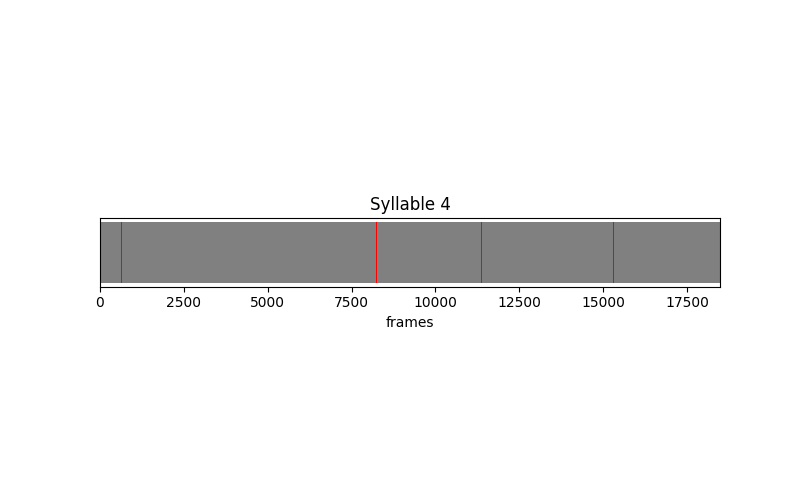

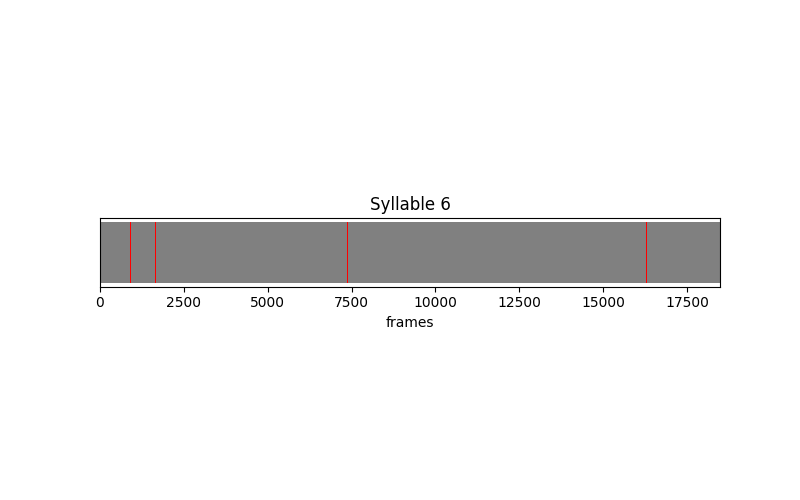

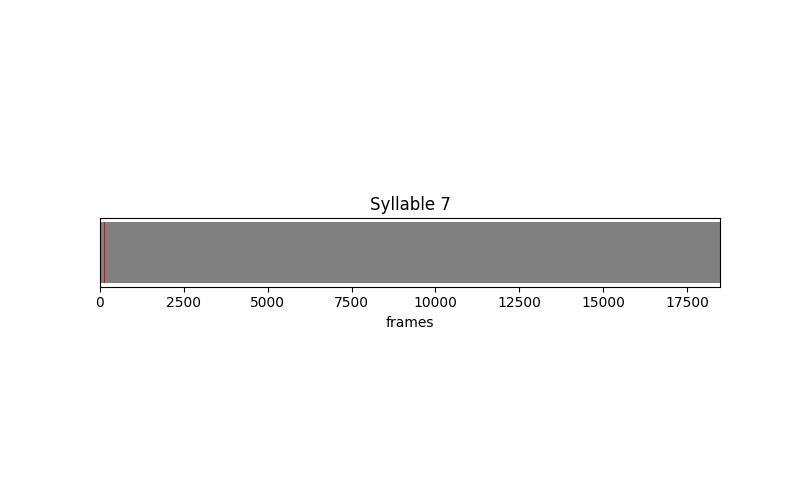

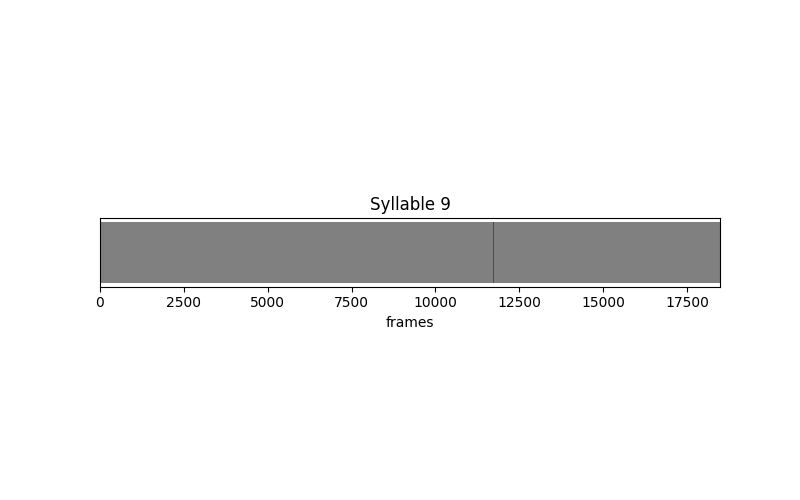

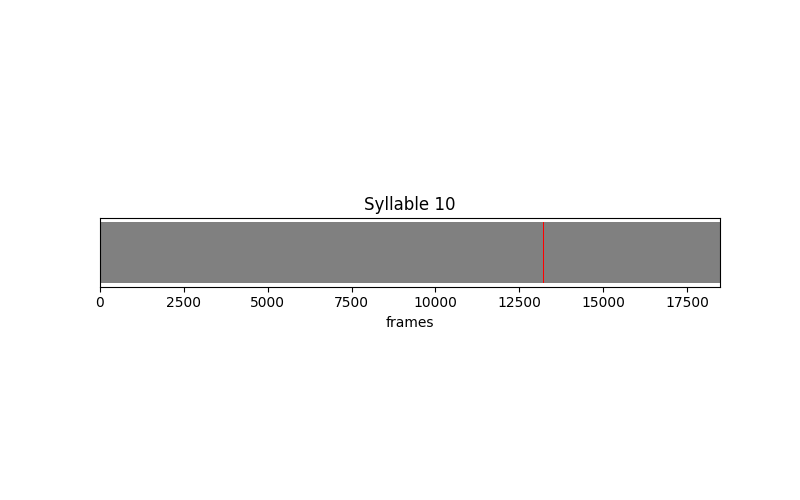

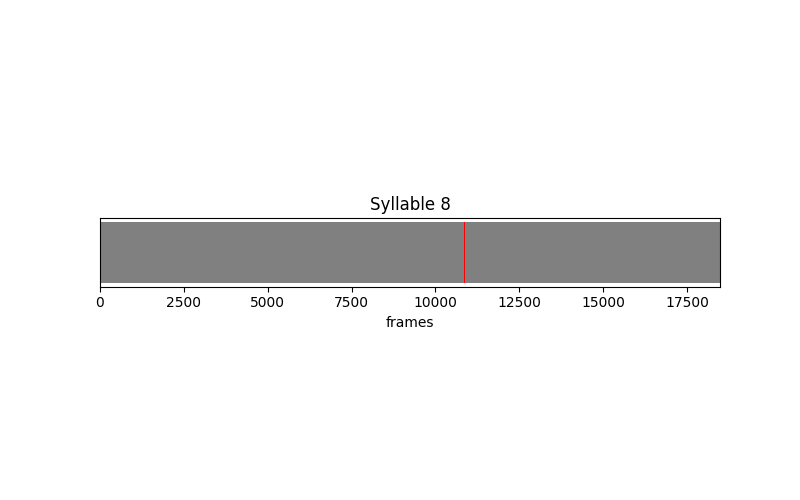

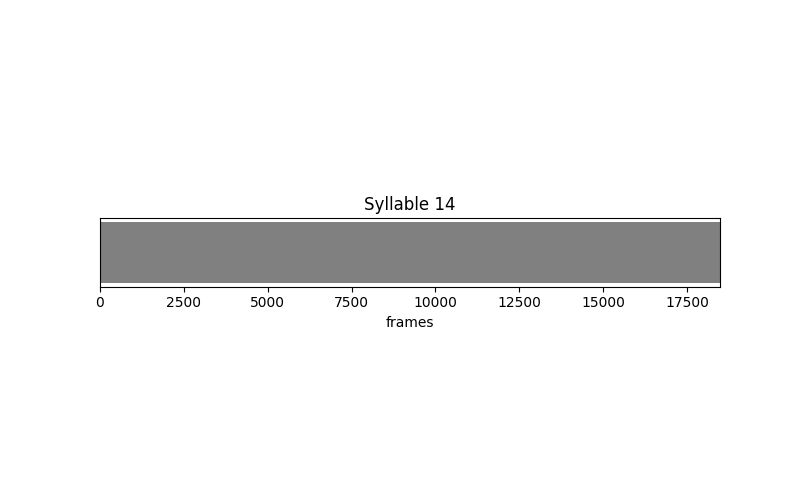

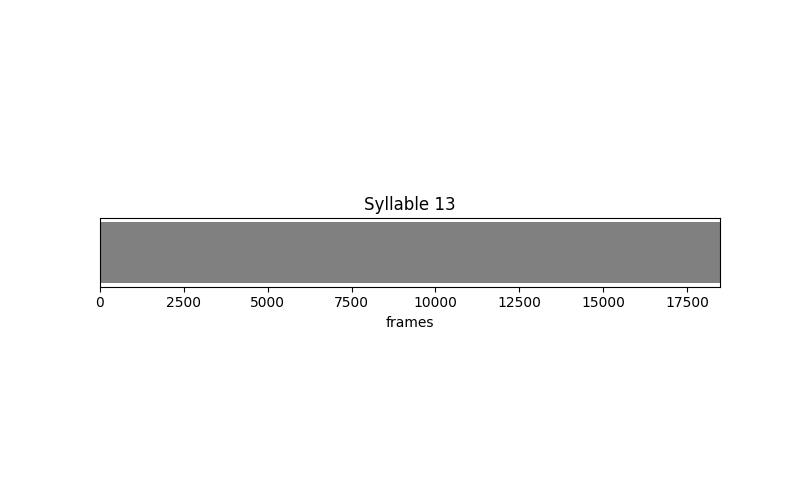

In [23]:
frames_max_to_plot = len(syllables_per_frame)

for selected_syl in syllables_count.keys():

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    rects = ax.barh(
        y=results.keys(),
        width=[syl_dur for syl_id, syl_dur in syllable_chunks],
        left=chunks_start[:-1],  # starting frame of each chunk
        height=1,
        color=[
            'red' if syl_id==selected_syl 
            else 'grey' 
            for syl_id, _ in syllable_chunks
        ],
    )
    # ax.bar_label(rects, label_type='center', color='white')
    ax.set_xlim(0, frames_max_to_plot)
    ax.set_xlabel('frames')
    ax.yaxis.set_visible(False)

    ax.set_aspect(int(frames_max_to_plot/10))
    ax.set_title(f'Syllable {selected_syl}')

For some of the syllables, only a few frames are found.

In [24]:
print(syllables_count)

{2: 8202, 0: 4542, 3: 2885, 5: 1693, 1: 749, 4: 179, 6: 131, 7: 39, 9: 22, 10: 17, 8: 15, 14: 6, 13: 5}


## G. Plot centroid location for the top three syllables

During model fitting, `keypoint-moseq` computes the centroid of the animal as a latent variable.

In this section, we plot the position of the centroid for the 3 most frequent syllables in the new data.

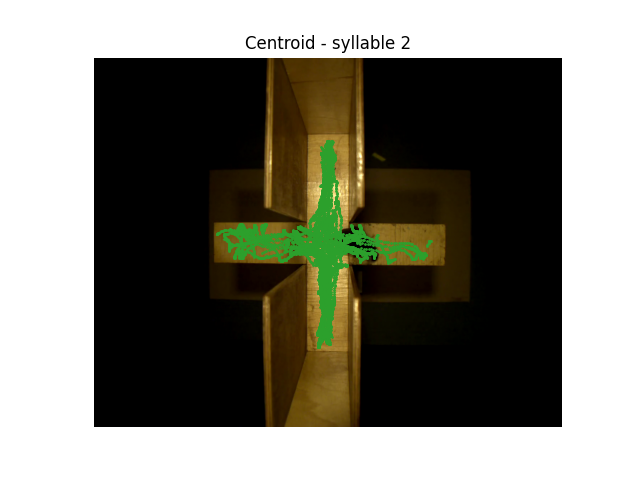

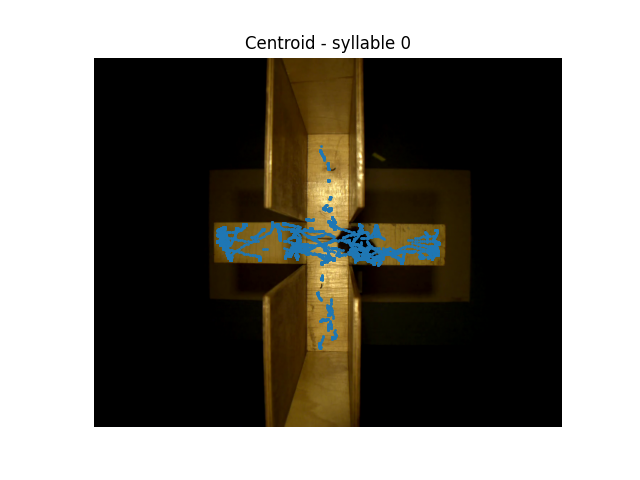

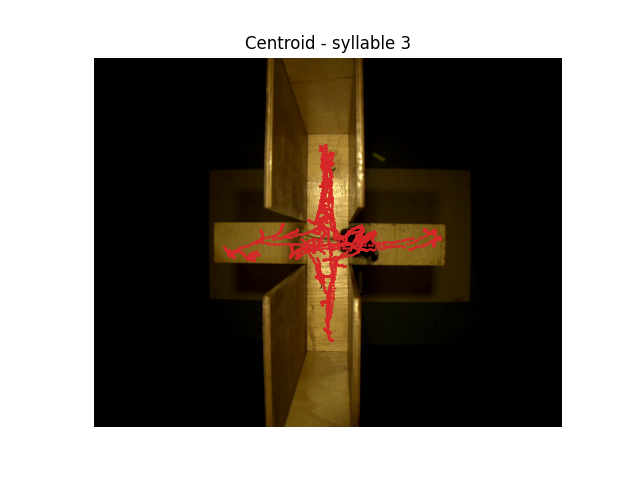

In [25]:
frame_img = plt.imread(video1_frame_file)

top_k_syllables = 3

centroid_array = results[filename_no_ext]['centroid']
syllable_array = results[filename_no_ext]['syllable']

for syl_id in list(syllables_count.keys())[:top_k_syllables]:

    fig, ax = plt.subplots(1,1)
    ax.imshow(frame_img)
    ax.scatter(
        x=centroid_array[syllable_array == syl_id,0],
        y=centroid_array[syllable_array == syl_id,1],
        s=1,
        color=list_colors[int(syl_id)%len(list_colors)]
    )

    ax.set_title(f'Centroid - syllable {syl_id}')
    ax.axis('off')


Some syllables seem to occur more frequently on specific areas (for example, syllable 0 seems to be identified more often when the mouse is on the open arms of the maze), whereas others seem more uniformly distributed (like syllable 2).

The same data can be expressed as a heatmap. Below we do that by first computing a 2D discretised probability density function for each of the top-3 syllables.

The values in the colorbar are proportional to the relative count of samples. Brighter colours indicate bins with a large number of samples relative to the total number of samples recorded for that syllable. The bins are 25 x 25 pixels in size.

We assume the DLC keypoint data is expressed in an image cooordinate system with the origin at the centre of the top-left pixel.
This is the case for [SLEAP](https://github.com/talmolab/sleap/discussions/1640#discussioncomment-7867277) and for [OpenCV](https://answers.opencv.org/question/35111/origin-pixel-in-the-image-coordinate-system-in-opencv/).

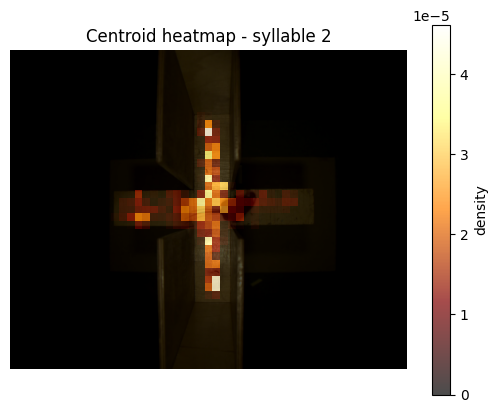

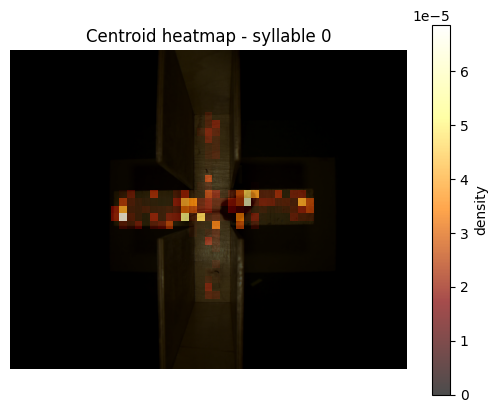

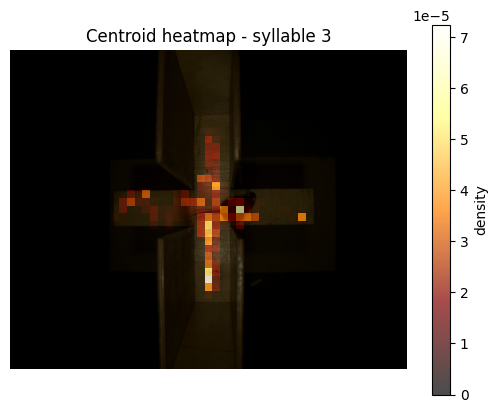

In [46]:
top_k_syllables = 3

centroid_array = results[filename_no_ext]['centroid']
syllable_array = results[filename_no_ext]['syllable']


for syl_id in list(syllables_count.keys())[:top_k_syllables]:
    fig, ax = plt.subplots(1,1)

    # image size: 1298 × 1028
    bin_width = 25 # in pixels
    x_edges_in = np.arange(-0.5, 1298, bin_width)
    y_edges_in = np.arange(-0.5, 1028, bin_width)

    heatmap, xedges, yedges = np.histogram2d(
        x=centroid_array[syllable_array == syl_id,0],
        y=centroid_array[syllable_array == syl_id,1],
        bins=[x_edges_in, y_edges_in], # xedges = yedges
        density=True,
    )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ax.imshow(frame_img)
    im = ax.imshow(
        heatmap.T, extent=extent, origin='lower', cmap="afmhot", alpha=0.7,
    )

    ax.set_title(f'Centroid heatmap - syllable {syl_id}')
    ax.axis('off')

    cb = fig.colorbar(im)
    cb.set_label('density')  #  (bin count / total samples / bin area)


## Appendix

The results in the .h5 file follow the structure below. 
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

### Other useful links from the `keypoint-moseq` docs:

- [An in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).

- More on [detecting existing syllables in new data](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#detecting-existing-syllables-in-new-data).

- More on [adding new data to the training set, and retraining (re-fitting) a model](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#continue-model-fitting-but-with-new-data).
